In [1]:
!gdown 1cjnX6skOIJwqhyfnYXCqkSPD522JTGeZ

Downloading...
From (original): https://drive.google.com/uc?id=1cjnX6skOIJwqhyfnYXCqkSPD522JTGeZ
From (redirected): https://drive.google.com/uc?id=1cjnX6skOIJwqhyfnYXCqkSPD522JTGeZ&confirm=t&uuid=82aa2596-e3d2-450b-9449-02d021e6e268
To: /content/Gestures.zip
100% 118M/118M [00:02<00:00, 40.7MB/s]


In [2]:
!unzip Gestures.zip

Archive:  Gestures.zip
   creating: Gestures/
   creating: Gestures/Close/
  inflating: Gestures/Close/video_20250306_210805.mp4  
  inflating: Gestures/Close/video_20250306_210817.mp4  
  inflating: Gestures/Close/video_20250306_210827.mp4  
  inflating: Gestures/Close/video_20250306_210835.mp4  
  inflating: Gestures/Close/video_20250306_210846.mp4  
   creating: Gestures/Down/
  inflating: Gestures/Down/video_20250306_211340.mp4  
  inflating: Gestures/Down/video_20250306_211345.mp4  
  inflating: Gestures/Down/video_20250306_211352.mp4  
  inflating: Gestures/Down/video_20250306_211359.mp4  
  inflating: Gestures/Down/video_20250306_211406.mp4  
   creating: Gestures/Left/
  inflating: Gestures/Left/video_20250306_211421.mp4  
  inflating: Gestures/Left/video_20250306_211427.mp4  
  inflating: Gestures/Left/video_20250306_211433.mp4  
  inflating: Gestures/Left/video_20250306_211438.mp4  
  inflating: Gestures/Left/video_20250306_211444.mp4  
   creating: Gestures/Open/
  inflating

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

NUM_FRAMES = 7
IMG_SIZE = (50, 50)
CLASSES = ["Close","Down","Left","Open","Right","Top"]
NUM_CLASSES = len(CLASSES)

def extract_frames(video_path, num_frames=NUM_FRAMES):
    """Extracts evenly spaced grayscale frames from a video."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count == 0:
        print(f"Skipping {video_path}, no frames!")
        return np.zeros((num_frames, *IMG_SIZE, 1))

    for i in np.linspace(0, frame_count - 1, num_frames, dtype=int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, IMG_SIZE)
            frame = frame / 255.0
            frames.append(frame[..., np.newaxis])

    cap.release()

    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)

X, y = [], []
dataset_path = "/content/Gestures"

for class_index, class_name in enumerate(CLASSES):
    class_path = os.path.join(dataset_path, class_name)
    for video_name in os.listdir(class_path):
        video_path = os.path.join(class_path, video_name)
        frames = extract_frames(video_path)
        X.append(frames)
        y.append(class_index)

X = np.array(X)
y = to_categorical(y, NUM_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, LSTM, Dense, Dropout, Reshape, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization

# ViT Encoder Layer
def TransformerEncoder(embed_dim, num_heads):
    inputs = Input(shape=(NUM_FRAMES, embed_dim))
    x = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    x = LayerNormalization()(x)
    x = Dense(embed_dim, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = LayerNormalization()(x)
    return Model(inputs, x)

# Full Model
def build_cnn_vit_lstm():
    inputs = Input(shape=(NUM_FRAMES, IMG_SIZE[0], IMG_SIZE[1], 1))

    x = Conv3D(32, kernel_size=(3,3,3), activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(1,2,2))(x)

    x = Conv3D(48, kernel_size=(3,3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(1,2,2))(x)

    x = Conv3D(64, kernel_size=(3,3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(1,2,2))(x)

    x = Reshape((NUM_FRAMES, -1))(x)

    vit = TransformerEncoder(embed_dim=x.shape[-1], num_heads=2)
    x = vit(x)

    x = LSTM(64, return_sequences=False)(x)

    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)

    return Model(inputs, outputs)

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model = build_cnn_vit_lstm()
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7, 50, 50, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 7, 50, 50, 32)       │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 7, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 7, 25, 25, 48)       │          41,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 25, 25, 48)       │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 12, 12, 48)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 7, 12, 12, 64)       │          83,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 12, 12, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 7, 6, 6, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 2304)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 7, 2304)             │      47,803,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         606,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,540,406 (185.17 MB)

 Trainable params: 48,540,118 (185.17 MB)

 Non-trainable params: 288 (1.12 KB)

In [5]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=3)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.0281 - loss: 2.0273 - val_accuracy: 0.3333 - val_loss: 1.8470
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1884 - loss: 1.8109 - val_accuracy: 0.3333 - val_loss: 1.9208
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0775 - loss: 1.7775 - val_accuracy: 0.3333 - val_loss: 1.8708
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.1437 - loss: 1.8183 - val_accuracy: 0.0000e+00 - val_loss: 1.7609
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1338 - loss: 1.8504 - val_accuracy: 0.0000e+00 - val_loss: 1.7572
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.0374 - loss: 1.8585 - val_accuracy: 0.0000e+00 - val_loss: 1.7767
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.0590 - loss: 1.8291 - val_accuracy: 0.0000e+00 - val_loss: 1.7906
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4355 - loss: 1.7400 - val_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Class: Right (Confidence: 1.00)


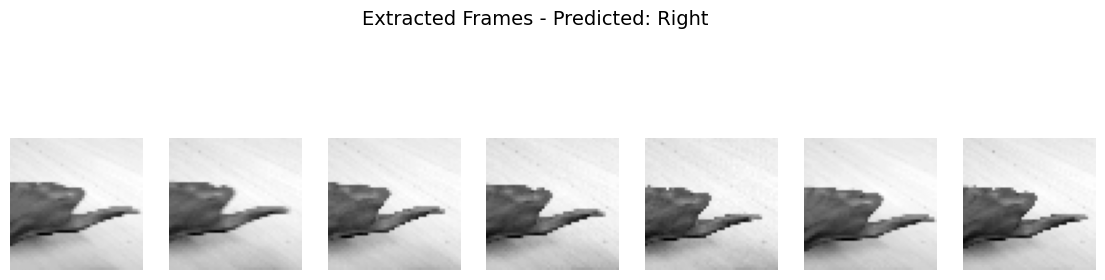

(4, 0.9994099)

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

NUM_FRAMES = 7
IMG_SIZE = (50, 50)
CLASSES = ["Close", "Down", "Left", "Open", "Right", "Top"]
NUM_CLASSES = len(CLASSES)

def extract_frames(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count == 0:
        print(f"Skipping {video_path}, no frames found!")
        return np.zeros((num_frames, *IMG_SIZE, 1))

    for i in np.linspace(0, frame_count - 1, num_frames, dtype=int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, IMG_SIZE)
            frame = frame / 255.0
            frames.append(frame[..., np.newaxis])

    cap.release()

    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)

def predict_video(video_path, model):
    frames = extract_frames(video_path)
    frames = np.expand_dims(frames, axis=0)

    prediction = model.predict(frames)
    class_idx = np.argmax(prediction)
    confidence = np.max(prediction)

    print(f"Predicted Class: {CLASSES[class_idx]} (Confidence: {confidence:.2f})")

    fig, axes = plt.subplots(1, 7, figsize=(14, 4))
    fig.suptitle(f"Extracted Frames - Predicted: {CLASSES[class_idx]}", fontsize=14)
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.rotate(frames[0, i, :, :, 0], cv2.ROTATE_90_CLOCKWISE), cmap="gray")
        ax.axis("off")
    plt.show()

    return class_idx, confidence

video_path = "/content/Gestures/Right/video_20250306_211456.mp4"
predict_video(video_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: Open (Confidence: 0.97)


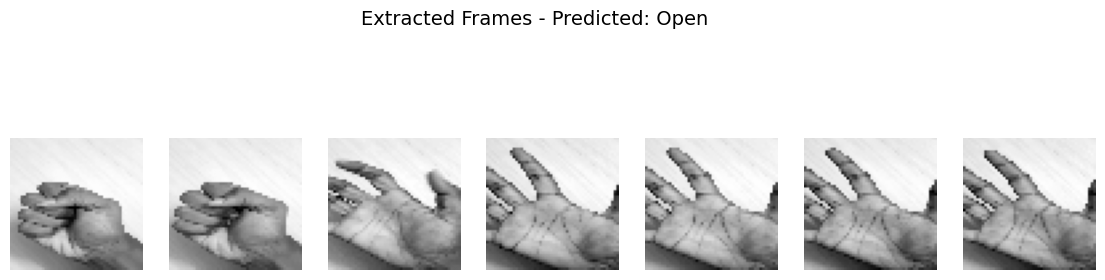

(3, 0.96739256)

In [9]:
# Example usage
video_path = "/content/Gestures/Open/video_20250306_211142.mp4"
predict_video(video_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Class: Close (Confidence: 0.98)


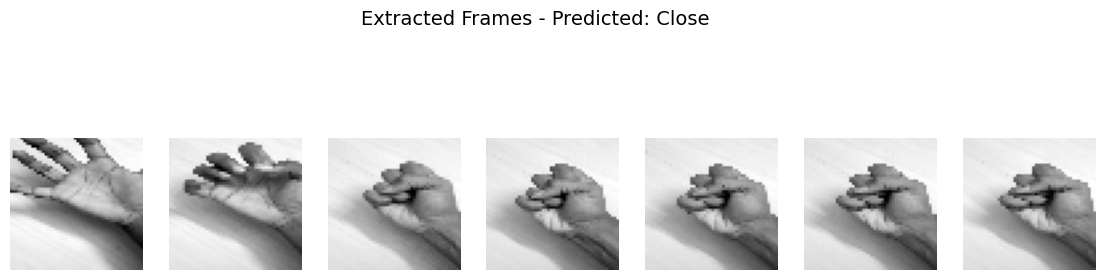

(0, 0.97706133)

In [10]:
# Example usage
video_path = "/content/Gestures/Close/video_20250306_210835.mp4"
predict_video(video_path, model)